In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, time, datetime, timedelta
from dateutil.parser import parse

In [3]:
import nomad.io.base as loader
import nomad.visit_attribution as visits
import nomad.stop_detection.lachesis as LACHESIS

In [4]:
def dawn_time(day_part, dawn_hour=6): # extracts the duration of dawn for a day part
    s,e = day_part
    return np.min([(e.hour*60 + e.minute),dawn_hour*60]) - np.min([(s.hour*60 + s.minute),dawn_hour*60]) 

def dusk_time(day_part, dusk_hour=19): # extracts the duration of dusk for a day part
    s,e = day_part
    return np.max([(e.hour*60 + e.minute)-dusk_hour*60,0]) - np.max([(s.hour*60 + s.minute)-dusk_hour*60, 0])

def slice_datetimes_interval_fast(start, end): # counts full days and tails
    full_days = (datetime.combine(end, time.min) - datetime.combine(start, time.max)).days
    if full_days >= 0:
        day_parts = [(start.time(), time.max), (time.min, end.time())]
    else:
        full_days = 0
        day_parts = [(start.time(), end.time()), (start.time(), start.time())]
    return full_days, day_parts

def duration_at_night_fast(start, end): #computes overlap
    dawn_hour = 6
    dusk_hour = 19
    full_days, (part1, part2) = slice_datetimes_interval_fast(start, end)
    total_dawn_time = dawn_time(part1, dawn_hour)+dawn_time(part2, dawn_hour)
    total_dusk_time = dusk_time(part1, dusk_hour)+dusk_time(part2, dusk_hour)
    return int(total_dawn_time + total_dusk_time + full_days*(dawn_hour + (24-dusk_hour))*60)

def clip_stays_date(traj, dates):
    start = pd.to_datetime(traj['start_datetime'])
    duration = traj['duration']

    # Ensure timezone-aware clipping bounds
    tz = start.dt.tz
    date_0 = pd.Timestamp(parse(dates[0]), tz=tz)
    date_1 = pd.Timestamp(parse(dates[1]), tz=tz)

    end = start + pd.to_timedelta(duration, unit='m')

    # Clip to date range
    start_clipped = start.clip(lower=date_0, upper=date_1)
    end_clipped = end.clip(lower=date_0, upper=date_1)

    # Recompute durations
    duration_clipped = ((end_clipped - start_clipped).dt.total_seconds() // 60).astype(int)
    duration_night = [duration_at_night_fast(s, e) for s, e in zip(start_clipped, end_clipped)]

    return pd.DataFrame({
        'id': traj['id'].values,
        'start': start_clipped,
        'duration': duration_clipped,
        'duration_night': duration_night,
        'location': traj['location']
    })

def count_nights(usr_polygon):   
    min_dwell = 10
    dawn_hour = 6
    dusk_hour = 19
    nights = set()
    weeks = set()

    for _, row in usr_polygon.iterrows():
        d = row['start']
        d = pd.to_datetime(d)
        full_days, (part1, part2) = slice_datetimes_interval_fast(d, d + pd.to_timedelta(row['duration'], unit='m'))

        dawn1 = dawn_time(part1, dawn_hour)
        dusk1 = dusk_time(part1, dusk_hour)
        dawn2 = dawn_time(part2, dawn_hour)
        dusk2 = dusk_time(part2, dusk_hour)

        if full_days == 0:
            if dawn1 >= min_dwell:
                night = d - timedelta(days=1)
                nights.add(night.date())
                weeks.add((night - timedelta(days=night.weekday())).date())

            if (dusk1 + dawn2) >= min_dwell:
                night = d
                nights.add(night.date())
                weeks.add((night - timedelta(days=night.weekday())).date())

            if dusk2 >= min_dwell:
                night = d + timedelta(days=1)
                nights.add(night.date())
                weeks.add((night - timedelta(days=night.weekday())).date())
        else:
            if dawn1 >= min_dwell:
                night = d - timedelta(days=1)
                nights.add(night.date())
                weeks.add((night - timedelta(days=night.weekday())).date())

            for t in range(full_days + 1):
                night = d + timedelta(days=t)
                nights.add(night.date())
                weeks.add((night - timedelta(days=night.weekday())).date())

            if dusk2 >= min_dwell:
                night = d + timedelta(days=full_days + 1)
                nights.add(night.date())
                weeks.add((night - timedelta(days=night.weekday())).date())

    identifier = usr_polygon['id'].iloc[0]
    location = usr_polygon['location'].iloc[0]

    return pd.DataFrame([{
        'id': identifier,
        'location': location,
        'night_count': len(nights),
        'week_count': len(weeks)
    }])

In [5]:
poi_table = gpd.read_file('garden_city.gpkg').set_index('building_id')

In [6]:
traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'timestamp':'timestamp'}

sparse_df = loader.from_file("./long-gc-data/", format="parquet", traj_cols=traj_cols,
                       parse_dates=True)

# Reproject from gc_coords to web mercator
sparse_df.loc[:,'x'] = (sparse_df['x'] - 2*4265699)
sparse_df.loc[:,'y'] = (sparse_df['y'] + 2*4392976)

# Select data from 1 user
user = sparse_df.uid.unique()[0]
user_sample = sparse_df.loc[sparse_df.uid == user].copy()

In [ ]:
DUR_MIN=5
DT_MAX=60
DELTA_ROAM=100

traj_cols = {'user_id':'uid',
             'x':'x',
             'y':'y',
             'datetime':'datetime'}

stop_table_lachesis = LACHESIS.lachesis(traj=user_sample,
                                        dur_min=DUR_MIN,
                                        dt_max=DT_MAX,
                                        delta_roam=DELTA_ROAM,
                                        traj_cols=traj_cols,
                                        keep_col_names=False,
                                        complete_output=True,
                                        datetime = 'datetime')

user_sample['cluster'] = LACHESIS._lachesis_labels(traj=user_sample,
                                            dur_min=DUR_MIN,
                                            dt_max=DT_MAX,
                                            delta_roam=DELTA_ROAM,
                                            traj_cols=traj_cols,
                                            datetime = 'datetime').values

pred_lachesis = visits.point_in_polygon(
                 data=stop_table_lachesis,
                 poi_table=poi_table,
                 traj_cols=traj_cols,
                 max_distance=2,
                 x='x',
                 y='y',
                 data_crs='EPSG:4326')

pred_lachesis

C:\Users\pacob\Documents\repositories\nomad-repo\nomad\filters.py:97: UserWarning: The input is timezone-naive. UTC will be assumed.Consider localizing to a timezone or passing a timezone offset column.
  warnings.warn(
C:\Users\pacob\Documents\repositories\nomad-repo\nomad\filters.py:97: UserWarning: The input is timezone-naive. UTC will be assumed.Consider localizing to a timezone or passing a timezone offset column.
  warnings.warn(
C:\Users\pacob\Documents\repositories\nomad-repo\nomad\visit_attribution.py:159: UserWarning: Argument `data_crs` not provided, assuming EPSG:4326
  warnings.warn("Argument `data_crs` not provided, assuming EPSG:4326")
C:\Users\pacob\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


> c:\users\pacob\documents\repositories\nomad-repo\nomad\visit_attribution.py(68)point_in_polygon()
     66             )
     67             pdb.set_trace()
---> 68             pings_df.groupby(cluster_label, as_index=False)['location'].agg(
     69                 lambda x: x.mode().iloc[0] if not x.mode().empty else None)
     70             stop_table['location'] = pings_df.location.values # Do we need Values?



ipdb>  p data


        uid   timestamp  longitude   latitude          x          y  \
0     allen  1704119640  38.321027 -36.667517  11.884196   7.485533   
1     allen  1704120120  38.320959 -36.667444  11.375352   8.156611   
160   allen  1704161760  38.320959 -36.667465  11.372794   7.969700   
161   allen  1704162600  38.321069 -36.667482  12.193677   7.811347   
162   allen  1704179040  38.320935 -36.667496  11.198534   7.681230   
...     ...         ...        ...        ...        ...        ...   
6077  allen  1706091960  38.321040 -36.667467  11.977526   7.943842   
6078  allen  1706093400  38.320935 -36.667509  11.198295   7.555486   
6079  allen  1706094120  38.320977 -36.667514  11.507877   7.510655   
6080  allen  1706114760  38.320012 -36.666997   4.350183  12.294505   
6081  allen  1706114880  38.320372 -36.667317   7.021152   9.335032   

                datetime     ha        date  tz_offset  cluster  
0    2024-01-01 16:34:00  11.25  2024-01-01       7200        0  
1    2024-01-01

ipdb>  p pings_df


        uid   timestamp  longitude   latitude          x          y  \
0     allen  1704119640  38.321027 -36.667517  11.884196   7.485533   
1     allen  1704120120  38.320959 -36.667444  11.375352   8.156611   
160   allen  1704161760  38.320959 -36.667465  11.372794   7.969700   
161   allen  1704162600  38.321069 -36.667482  12.193677   7.811347   
163   allen  1704209520  38.321391 -36.666826  14.580977  13.880322   
...     ...         ...        ...        ...        ...        ...   
6075  allen  1706091480  38.320877 -36.667459  10.769694   8.020328   
6076  allen  1706091600  38.321020 -36.667476  11.829863   7.869353   
6077  allen  1706091960  38.321040 -36.667467  11.977526   7.943842   
6078  allen  1706093400  38.320935 -36.667509  11.198295   7.555486   
6079  allen  1706094120  38.320977 -36.667514  11.507877   7.510655   

                datetime     ha        date  tz_offset  cluster location  
0    2024-01-01 16:34:00  11.25  2024-01-01       7200        0      NaN

ipdb>  p pings_df.location.value_counts()


Series([], Name: count, dtype: int64)


ipdb>  p poi_map(                 data=pings_df,                 poi_table=poi_table,                 max_distance=max_distance,                 data_crs=data_crs,                 traj_cols=traj_cols,                 **kwargs                             )


C:\Users\pacob\Documents\repositories\nomad-repo\nomad\visit_attribution.py:159: UserWarning: Argument `data_crs` not provided, assuming EPSG:4326
  warnings.warn("Argument `data_crs` not provided, assuming EPSG:4326")
C:\Users\pacob\AppData\Local\Programs\Python\Python312\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


0       NaN
1       NaN
160     NaN
161     NaN
163     NaN
       ... 
6075    NaN
6076    NaN
6077    NaN
6078    NaN
6079    NaN
Name: building_id, Length: 226, dtype: object


In [22]:
user_sample

,uid,timestamp,longitude,latitude,x,y,datetime,ha,date,tz_offset,cluster
0,allen,1704119640,38.321027,-36.667517,11.884196,7.485533,2024-01-01 16:34:00,11.25,2024-01-01,7200,0
1,allen,1704120120,38.320959,-36.667444,11.375352,8.156611,2024-01-01 16:42:00,11.25,2024-01-01,7200,0
160,allen,1704161760,38.320959,-36.667465,11.372794,7.969700,2024-01-02 04:16:00,11.25,2024-01-02,7200,1
161,allen,1704162600,38.321069,-36.667482,12.193677,7.811347,2024-01-02 04:30:00,11.25,2024-01-02,7200,1
162,allen,1704179040,38.320935,-36.667496,11.198534,7.681230,2024-01-02 09:04:00,11.25,2024-01-02,7200,-1
...,...,...,...,...,...,...,...,...,...,...,...
6077,allen,1706091960,38.321040,-36.667467,11.977526,7.943842,2024-01-24 12:26:00,11.25,2024-01-24,7200,37
6078,allen,1706093400,38.320935,-36.667509,11.198295,7.555486,2024-01-24 12:50:00,11.25,2024-01-24,7200,37
6079,allen,1706094120,38.320977,-36.667514,11.507877,7.510655,2024-01-24 13:02:00,11.25,2024-01-24,7200,37
6080,allen,1706114760,38.320012,-36.666997,4.350183,12.294505,2024-01-24 18:46:00,11.25,2024-01-24,7200,-1


In [ ]:
# stop detection output
stop_table_lachesis['start_datetime'] = pd.to_datetime(stop_table_lachesis['start_datetime'])

if 'id' not in stop_table_lachesis.columns:
    stop_table_lachesis['id'] = user

# Date range
start_date = "2024-01-02"
weeks = 2
end_date = (parse(start_date) + timedelta(weeks=weeks)).date().isoformat()
dates = (start_date, end_date)
df_clipped = clip_stays_date(stop_table_lachesis, dates)
df_clipped = df_clipped[(df_clipped['duration'] > 0) & (df_clipped['duration_night'] >= 15)]
df_clipped.groupby(['id', 'location'], group_keys=False).apply(count_nights).reset_index(drop=True)

In [1]:
# !pip install -q git+https://github.com/Watts-Lab/nomad.git@IC2S2-tutorial

# import gdown
# gdown.cached_download(
#     "https://drive.google.com/uc?id=1wk3nrNsmAiBoTtWznHjjjPkmWAZfxk0P",
#     path="IC2S2_2025.zip",
#     quiet=False,
#     postprocess=gdown.extractall,  # auto-unzip
# )

In [2]:
import geopandas as gpd
from shapely.geometry import Polygon, box, Point
import matplotlib.pyplot as plt

import nomad.io.base as loader
from nomad.stop_detection.viz import plot_pings

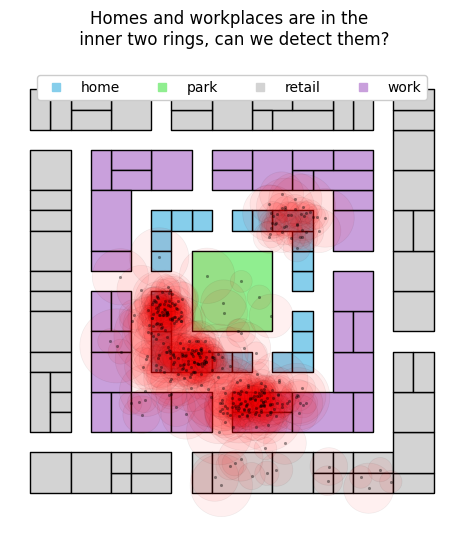

In [3]:
poi_table = gpd.read_file('garden_city.gpkg').set_index('building_id')

city_bounds = box(*poi_table.total_bounds)
color_map = {"home":"#86ceeb", "park":"#90ee90", "retail":"#d3d3d3", "work":"#c9a0dc"}

tc = {"user_id": "gc_identifier","timestamp": "unix_ts","x":"dev_x", "y":"dev_y"}

traj = loader.sample_from_file('gc_data_long/',
                               format='parquet',
                               users=['confident_aryabhata'],
                               within=city_bounds, # spatial filters
                               filters=[("ha", "<", 30), ("date", "<", '2024-01-04')], # regular filters
                               data_crs="EPSG:3857",
                               traj_cols=tc)

fix, ax = plt.subplots(figsize=(5,5))

ax.set_axis_off()
poi_table.plot(ax=ax, color=poi_table["type"].map(color_map), edgecolor="black")

plot_pings(traj, ax=ax, point_color='black',
           radius="ha", circle_alpha=0.06, circle_color="red", # for horizontal accuracy
           s=5, alpha=0.4, # <<<<<< for pings
           traj_cols=tc)

[plt.plot([],[], marker="s", ls="", color=color_map[t], label=t) for t in color_map]
ax.legend(loc="upper center", ncol=4, fontsize=10, framealpha=1)

plt.tight_layout()
plt.title("Homes and workplaces are in the \n inner two rings, can we detect them?")
plt.show()

In [4]:
import numpy as np
import pandas as pd
pd.set_option("mode.copy_on_write", True)
from nomad import filters


stops = loader.sample_from_file("gc_data_stops/",
                                format='parquet',
                                users=['confident_aryabhata'], # <<<< single user
                                user_id="gc_identifier")

stops['datetime'] = pd.to_datetime(stops['start_timestamp'], unit='s', utc=True).dt.tz_convert('Etc/GMT-1')

In [5]:
import nomad.visit_attribution.visit_attribution as visits

stops["location_id"] = visits.point_in_polygon(
                         data=stops,
                         poi_table=poi_table,
                         max_distance=15,  # TRY max_distance = 0
                         x='x',
                         y='y',
                         method='centroid',
                         data_crs='EPSG:3857')

stops.location_id.value_counts().head(15)

C:\Users\pacob\AppData\Local\Programs\Python\Python312\Lib\site-packages\nomad\visit_attribution\visit_attribution.py:223: UserWarning: location_id column not provided, defaulting to poi_table.index for spatial join.
  warnings.warn(f"location_id column not provided, defaulting to poi_table.index for spatial join.")


location_id
w-x12-y6     85
h-x9-y8      84
h-x13-y13    47
p-x13-y11    19
h-x10-y8     15
w-x12-y3     14
h-x11-y8     13
h-x7-y15     12
h-x8-y10     11
h-x12-y13    10
h-x8-y8       9
h-x13-y9      8
w-x3-y6       7
w-x8-y6       7
w-x15-y3      6
Name: count, dtype: int64

In [6]:
import nomad.stop_detection.lachesis as LACHESIS
from nomad.stop_detection.utils import summarize_stop

tc = {"user_id": "gc_identifier", "timestamp": "unix_ts", "x": "dev_x", "y": "dev_y", "ha":"ha", "date":"date"}

traj = loader.sample_from_file("gc_data_long/", format='parquet', users=['confident_aryabhata'], traj_cols=tc)
traj["cluster"] = LACHESIS.lachesis_labels(traj, delta_roam=30, dt_max=240, complete_output=True, traj_cols=tc)

traj["location_id"] = visits.point_in_polygon(
                         data=traj,
                         poi_table=poi_table,
                         max_distance=15,  # try switching to max_distance = 0
                         x='dev_x',
                         y='dev_y',
                         method='majority',
                         data_crs='EPSG:3857')

stops_maj = traj[traj.cluster!=-1].groupby('cluster', as_index=False).apply(lambda df: summarize_stop(
                                                                                df,
                                                                                complete_output=True,
                                                                                keep_col_names=False,
                                                                                passthrough_cols=['location_id', 'gc_identifier'],
                                                                                traj_cols=tc), include_groups=False
                                                                            )

stops_maj.location_id.value_counts().head(15)

C:\Users\pacob\AppData\Local\Programs\Python\Python312\Lib\site-packages\nomad\visit_attribution\visit_attribution.py:223: UserWarning: location_id column not provided, defaulting to poi_table.index for spatial join.
  warnings.warn(f"location_id column not provided, defaulting to poi_table.index for spatial join.")


location_id
h-x9-y8      85
w-x12-y6     79
h-x13-y13    47
w-x12-y3     18
h-x10-y8     18
p-x13-y11    17
h-x11-y8     13
h-x7-y15     12
h-x8-y10     11
h-x12-y13    11
h-x8-y8      10
w-x3-y6       8
h-x13-y9      8
w-x15-y3      7
h-x13-y12     6
Name: count, dtype: int64

In [7]:
stops = loader.from_file("gc_data_stops/", format='parquet', user_id="gc_identifier")
stops['datetime'] = pd.to_datetime(stops['start_timestamp'], unit='s', utc=True).dt.tz_convert('Etc/GMT-1')

stops["location_id"] = visits.point_in_polygon(
                         data=stops,
                         poi_table=poi_table,
                         max_distance=10,
                         x='x',
                         y='y',
                         method='centroid',
                         data_crs='EPSG:3857')

C:\Users\pacob\AppData\Local\Programs\Python\Python312\Lib\site-packages\nomad\visit_attribution\visit_attribution.py:223: UserWarning: location_id column not provided, defaulting to poi_table.index for spatial join.
  warnings.warn(f"location_id column not provided, defaulting to poi_table.index for spatial join.")


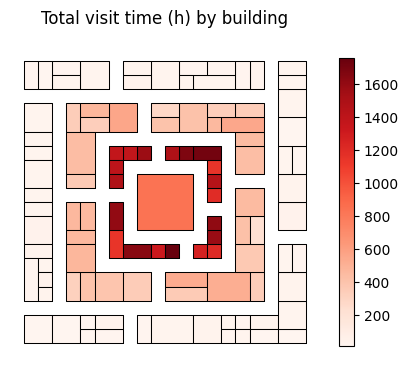

In [8]:
import matplotlib.pyplot as plt

poi_table['total_visit_time_hrs'] = stops.groupby("location_id").agg({"duration":"sum"})//60

fig, ax1 = plt.subplots(figsize=(5,5))
ax1.set_axis_off()

poi_table.plot(ax=ax1, column='total_visit_time_hrs', cmap='Reds', edgecolor='black', linewidth=0.75, legend=True, legend_kwds={'shrink': 0.75})
plt.title("Total visit time (h) by building")
plt.show()

In [9]:
stops['start_datetime'] = filters.to_zoned_datetime(stops['start_timestamp'], stops['tz_offset'])
stops['end_datetime'] = filters.to_zoned_datetime(stops['end_timestamp'], stops['tz_offset'])
stops.drop(['start_timestamp', 'end_timestamp'], axis=1, inplace=True)

In [10]:
%%time
import nomad.visit_attribution.home_attribution as homes
from datetime import date

cand_homes = homes.compute_candidate_homes(stops,
                                           datetime="datetime",
                                           location_id="location_id",
                                           user_id="gc_identifier",
                                           dawn_hour=6,
                                           dusk_hour=19
                                           )
cand_homes

CPU times: total: 13.7 s
Wall time: 13.8 s


,gc_identifier,location_id,num_nights,num_weeks,total_duration
0,admiring_cray,h-x11-y8,1,1,58
1,admiring_cray,h-x13-y11,2,1,130
2,admiring_cray,h-x13-y12,1,1,128
3,admiring_cray,h-x6-y13,14,3,2202
4,admiring_cray,h-x7-y15,4,2,145
...,...,...,...,...,...
4776,zen_colden,h-x13-y13,2,1,390
4777,zen_colden,h-x8-y8,1,1,53
4778,zen_colden,h-x9-y8,15,3,2483
4779,zen_colden,p-x13-y11,4,3,86


A simple query can now find candidate locations satisfying:
- `num_nights >= min_days`
- `num_weeks >= min_weeks`
- break ties using the total dwell at night (`total_duration`)

In [11]:
last_date = date(year=2024, month=1, day=21) # needed for rolling home computations
home_table = homes.select_home(cand_homes, min_days=4, min_weeks=2, last_date=last_date, user_id='gc_identifier')
home_table

,gc_identifier,location_id,date_last_active
0,admiring_cray,h-x6-y13,2024-01-21
1,admiring_curie,h-x13-y8,2024-01-21
2,admiring_euclid,h-x9-y8,2024-01-21
3,admiring_hawking,h-x13-y9,2024-01-21
4,admiring_kapitsa,h-x11-y8,2024-01-21
...,...,...,...
343,youthful_thompson,h-x15-y13,2024-01-21
344,youthful_wilson,h-x11-y8,2024-01-21
345,zealous_cray,h-x9-y13,2024-01-21
346,zealous_ramanujan,h-x11-y13,2024-01-21


In [12]:
print(f"{100*len(home_table)/len(stops.gc_identifier.unique()):.2f}% of users have a detected home")
print(f"{100*(home_table.location_id.str[0] == 'h').sum()/len(stops.gc_identifier.unique()):.2f}% of users have a home of type 'home'")

99.43% of users have a detected home
99.43% of users have a home of type 'home'


## Work locations and OD matrix

In [113]:
homes.workday_stops(stops, work_start_hour=11,
    work_end_hour=13).query("gc_identifier == 'admiring_cray'").groupby('location_id').duration.sum().sort_values()

location_id
h-x13-y8      9
h-x14-y6     45
h-x8-y12     93
h-x6-y13    177
Name: duration, dtype: int64

In [ ]:
stops_work = homes.workday_stops(stops)

In [105]:
stops_work.query("datetime < start_datetime")

,cluster,x,y,duration,diameter,n_pings,max_gap,gc_identifier,datetime,location_id,start_datetime,end_datetime
29,21,-4.265587e+06,4.393164e+06,49,26.785711,14,33,admiring_cray,2024-01-03 07:47:54+01:00,h-x8-y12,2024-01-03 09:00:00+01:00,2024-01-03 09:49:45+01:00
41,33,-4.265480e+06,4.393153e+06,13,29.405259,13,14,admiring_cray,2024-01-04 08:17:16+01:00,h-x13-y11,2024-01-04 09:00:00+01:00,2024-01-04 09:13:48+01:00
56,48,-4.265597e+06,4.393170e+06,7,19.982223,7,12,admiring_cray,2024-01-05 08:38:22+01:00,h-x8-y12,2024-01-05 09:00:00+01:00,2024-01-05 09:07:17+01:00
127,118,-4.265578e+06,4.393182e+06,68,28.918173,10,116,admiring_cray,2024-01-12 07:31:26+01:00,h-x6-y13,2024-01-12 09:00:00+01:00,2024-01-12 10:08:45+01:00
166,157,-4.265590e+06,4.393163e+06,121,29.483661,17,210,admiring_cray,2024-01-16 05:43:18+01:00,h-x8-y12,2024-01-16 09:00:00+01:00,2024-01-16 11:01:56+01:00
...,...,...,...,...,...,...,...,...,...,...,...,...
73835,37,-4.265519e+06,4.393193e+06,171,26.147033,10,120,zealous_ramanujan,2024-01-12 07:54:48+01:00,h-x11-y13,2024-01-12 09:00:00+01:00,2024-01-12 11:51:16+01:00
73866,68,-4.265520e+06,4.393192e+06,53,16.268998,3,78,zealous_ramanujan,2024-01-18 08:10:13+01:00,h-x11-y13,2024-01-18 09:00:00+01:00,2024-01-18 09:53:58+01:00
73893,15,-4.265553e+06,4.393099e+06,13,26.038247,2,20,zen_colden,2024-01-04 08:53:36+01:00,h-x9-y8,2024-01-04 09:00:00+01:00,2024-01-04 09:13:53+01:00
73895,17,-4.265555e+06,4.393085e+06,109,25.914186,8,41,zen_colden,2024-01-05 08:42:05+01:00,h-x9-y8,2024-01-05 09:00:00+01:00,2024-01-05 10:49:24+01:00


In [13]:
cand_works =homes.compute_candidate_workplaces(stops,
                                               datetime="datetime",
                                               location_id="location_id",
                                               user_id="gc_identifier",
                                               work_start_hour=10,
                                               work_end_hour=12,
                                               include_weekends=False)

work_table = homes.select_workplace(cand_works, last_date=last_date, min_days=3,min_weeks=2, user_id='gc_identifier')

print(f"{100*len(work_table)/len(stops.gc_identifier.unique()):.2f}% of users have a detected workplace")
print(f"{100*(work_table.location_id.str[0] == 'w').sum()/len(stops.gc_identifier.unique()):.2f}% of users have a workplace of type 'work'.")

99.43% of users have a detected workplace
98.57% of users have a workplace of type 'work'.


In [14]:
import pydeck
origin = home_table.set_index('gc_identifier').location_id
origin.name = "origin"

destination = work_table.set_index('gc_identifier').location_id
destination.name = "destination"

od = (pd.DataFrame([origin,destination]).T).dropna()
od = od.groupby(by=['origin', 'destination']).size().reset_index(name='count')

In [16]:
from nomad.visit_attribution.viz import plot_od_map

# a little background
outer_box = box(*poi_table.total_bounds).buffer(15, join_style='mitre')
outer_box = outer_box.difference(poi_table.geometry.union_all())

background = poi_table.copy()
background['color'] = '#adadad'
background = pd.concat([background, gpd.GeoDataFrame({'geometry':outer_box, 'color':'#616161'}, index=['outline'], crs="EPSG:3857")])

plot_od_map(od_df=od,
   region_gdf=poi_table,
   origin_col="origin",
   dest_col="destination",
   weight_col="count",
   edge_alpha=0.85,
   edge_cmap="Reds", # try Reds, viridis, plasma
   w_min=3, # try 1 or 3
   background_gdf=background)

{
  "initialViewState": {
    "latitude": 36.669514924531235,
    "longitude": -38.31794387131478,
    "pitch": 30,
    "zoom": 17
  },
  "layers": [
    {
      "@@type": "GeoJsonLayer",
      "data": [
        {
          "color": "#adadad",
          "fill_color": [
            173,
            173,
            173,
            255
          ],
          "geometry": {
            "coordinates": [
              [
                [
                  -38.31767437672955,
                  36.66929877196072
                ],
                [
                  -38.31767437672955,
                  36.66973109167419
                ],
                [
                  -38.31821336590002,
                  36.66973109167419
                ],
                [
                  -38.31821336590002,
                  36.66929877196072
                ],
                [
                  -38.31767437672955,
                  36.66929877196072
                ]
              ]
            ],
            "type": "Polygon"
          },
          "total_visit_time_hrs": 836,
          "type": "park"
        },
        {
          "color": "#adadad",
          "fill_color": [
            173,
            173,
            173,
            255
          ],
          "geometry": {
            "coordinates": [
              [
                [
                  -38.31834811319264,
                  36.66908261119321
                ],
                [
                  -38.31834811319264,
                  36.66929877196072
                ],
                [
                  -38.318482860485254,
                  36.66929877196072
                ],
                [
                  -38.318482860485254,
                  36.66908261119321
                ],
                [
                  -38.31834811319264,
                  36.66908261119321
                ]
              ]
            ],
            "type": "Polygon"
          },
          "total_visit_time_hrs": 1147,
          "type": "home"
        },
        {
          "color": "#adadad",
          "fill_color": [
            173,
            173,
            173,
            255
          ],
          "geometry": {
            "coordinates": [
              [
                [
                  -38.31807861860741,
                  36.66908261119321
                ],
                [
                  -38.31807861860741,
                  36.669190691652865
                ],
                [
                  -38.31834811319264,
                  36.669190691652865
                ],
                [
                  -38.31834811319264,
                  36.66908261119321
                ],
                [
                  -38.31807861860741,
                  36.66908261119321
                ]
              ]
            ],
            "type": "Polygon"
          },
          "total_visit_time_hrs": 1641,
          "type": "home"
        },
        {
          "color": "#adadad",
          "fill_color": [
            173,
            173,
            173,
            255
          ],
          "geometry": {
            "coordinates": [
              [
                [
                  -38.31794387131478,
                  36.66908261119321
                ],
                [
                  -38.31794387131478,
                  36.669190691652865
                ],
                [
                  -38.31807861860741,
                  36.669190691652865
                ],
                [
                  -38.31807861860741,
                  36.66908261119321
                ],
                [
                  -38.31794387131478,
                  36.66908261119321
                ]
              ]
            ],
            "type": "Polygon"
          },
          "total_visit_time_hrs": 1321,
          "type": "home"
        },
        {
          "color": "#adadad",
          "fill_color": [
            173,
            173,
            173